
# Example 1 — Pipe network: nodal heads and flow rates

This example reproduces **Example 4.2** from:

> Brebbia, C. A., & Ferrante, A. J. (2013). *Computational Hydraulics*. Butterworth-Heinemann.

<img src = "images/example4_2.svg" width = "350"> 

The objective is to compute:

* **nodal hydraulic heads** $H$,
* **element flow rates** $Q$,

for a pipe network with known boundary conditions.

---

## 1. Physical problem description

The pipe system consists of:

* **4 nodes** (junctions),
* **5 pipes** (elements).

Each pipe is characterized by its **length** $L_i$ and **diameter** $D_i$.
Some nodes have:

* prescribed **hydraulic head** $H$,
* prescribed **flow demand** $C$ (inlet or outlet).

Given data:

* $L_0 = 1000\ \mathrm{m}$, $D_0 = 0.4\ \mathrm{m}$
* $L_1 = 1000\ \mathrm{m}$, $D_1 = 0.2\ \mathrm{m}$
* $L_2 = 2000\ \mathrm{m}$, $D_2 = 0.283\ \mathrm{m}$
* $L_3 = 2000\ \mathrm{m}$, $D_3 = 0.283\ \mathrm{m}$
* $L_4 = 2000\ \mathrm{m}$, $D_4 = 0.573\ \mathrm{m}$

Boundary conditions:

* $C_1 = 10\ \mathrm{m^3/s}$
* $C_2 = 10\ \mathrm{m^3/s}$
* $H_3 = 10\ \mathrm{m}$
* $H_0 = 20\ \mathrm{m}$  
---

## 2. Governing equations

Each pipe is modeled as a **linear diffusive element** under laminar flow conditions.

For an element $i$ connecting nodes $k$ and $j$:

$$
\begin{bmatrix} Q_k^i \\ Q_j^i \end{bmatrix} = k^i \begin{bmatrix} 1 & -1 \\ -1 & 1 \end{bmatrix} \begin{bmatrix} H_k^i \\ H_j^i \end{bmatrix}
$$

where the hydraulic conductance is:

$$
k^i = \frac{\pi g D_i^4}{128 L_i \nu}
$$

with:

* $g$ gravitational acceleration,
* $\nu$ kinematic viscosity.

This formulation is fully analogous to a **diffusion operator**, which is why the system type is `"diffusive"`.

---

## 3. Step 1 — Create the network topology

We start by defining the **connectivity matrix**, which describes how nodes are linked by pipes.

In [1]:
import numpy as np
import netsystems as ns

In [2]:
# ------------------------
# STEP 1: Network topology
# ------------------------
net = ns.Network()

connectivity = np.array([
    [0, 1],
    [0, 2],
    [1, 2],
    [1, 3],
    [2, 3]
])

net.set_connectivity(connectivity)

Each row `[i, j]` represents one pipe connecting node `i` to node `j`.

## 4. Step 2 — Define the physical system (fluid)

We now define a **diffusive system** representing the hydraulic problem.

In [3]:
# ------------------------
# STEP 2: Fluid system
# ------------------------
fluid = ns.System("fluid", system_type="diffusive")

fluid.x_name = "H"                     # nodal head
fluid.b_name = "C"                     # nodal flow - flow demand
fluid.element_variable_name = "Q"      # element flow - flow rate

This establishes:

* $x \rightarrow H$ (nodal head),
* $b \rightarrow C$ (nodal flow),
* edge variable $\rightarrow Q$ (pipe flow).

---

## 5. Step 3 — Apply boundary conditions

### Known heads (Dirichlet conditions)

In [4]:
fluid.known_x_nodes = np.array([0, 3])
fluid.known_x_values = np.array([20, 10])

This means:

* $H_0 = 20\ \mathrm{m}$,
* $H_3 = 10\ \mathrm{m}$.

### Known nodal flows (sources / sinks)

In [5]:
fluid.known_b_nodes = np.array([1, 2])
fluid.known_b_values = np.array([10, 10])

This imposes:

* $C_1 = 10\ \mathrm{m^3/s}$,
* $C_2 = 10\ \mathrm{m^3/s}$.

---

## 6. Step 4 — Define pipe properties

We compute the conductance $k^i$ for each pipe.


In [6]:
# ------------------------
# STEP 4: Element properties
# ------------------------
d = np.array([0.4, 0.2, 0.283, 0.283, 0.573])
L = np.array([1000, 1000, 2000, 2000, 2000])

nu = 1e-6
g = 9.81

fluid.element_conductance = np.pi * g * d**4 / (128.0 * nu * L)

At this point:

* the system is **linear**,
* the element properties are constant.

---

## 7. Step 5 — Add the system to the network

In [7]:
net.add_system(fluid)

This step:

* attaches the system to the network,
* allows global assembly and solving.

---

## 8. Step 6 — Solve the linear system

In [8]:
ns.solve_linear_system(net, "fluid")

0

Internally, this performs:

1. global matrix assembly,
2. partitioning into known and unknown nodes,
3. solution of the reduced linear system,
4. reconstruction of full nodal heads,
5. computation of pipe flow rates.

---

## 9. Step 7 — Accessing results

### Nodal heads

```python
net.system("fluid").get("nodal_head")
net.system("fluid").x
net.get("nodal_head")
```

### Nodal flow balance

```python
net.system("fluid").b
net.get("nodal_flow")
```

### Pipe flow rates

```python
net.get("flow_rate")
```

In [9]:
net.get("Q")

array([ 3.42943368,  3.27610271,  6.13715863,  7.29227505, 19.41326134])

In [11]:
net.get("H")

array([20.        , 19.44361741, 11.49589496, 10.        ])

## 10. Step 8 — Inspecting the global matrix

### Obtain the assembled matrix

In [12]:
fluid_matrix = ns.get_global_matrix_csr(net, "fluid")
print(fluid_matrix.todense())

[[  6.54904259  -6.16380479  -0.3852378    0.        ]
 [ -6.16380479   7.70818651  -0.77219086  -0.77219086]
 [ -0.3852378   -0.77219086  14.13511886 -12.9776902 ]
 [  0.          -0.77219086 -12.9776902   13.74988106]]


### Visualize sparsity pattern

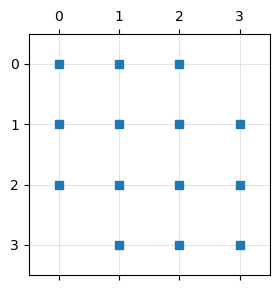

(<Figure size 300x300 with 1 Axes>, <Axes: >)

In [13]:
ns.spy_matrix(
    fluid_matrix,
    title=None,
    markersize=6,
    figsize=(3, 3)
)

## 11. Summary of the workflow

1. Define network topology
2. Define physical system (diffusive)
3. Apply boundary conditions
4. Compute element conductances
5. Assemble and solve the linear system
6. Postprocess nodal heads and pipe flows